# Layerwise_Relevance
this code has been adapted from [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import math
import torchvision.transforms as transforms
from torchvision import models

#Read an image
from PIL import Image
import requests
from io import BytesIO
url ="https://github.com/SalvatoreRa/CNNscan/blob/main/img/manja-vitolic-gKXKBY-C-Dk-unsplash.jpg?raw=true"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

#choose the model
pret_mod = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 137MB/s]


In [5]:
from copy import deepcopy
from matplotlib import cm
import copy
from torch.nn import ReLU
from torch.autograd import Variable


def apply_heatmap(R, sx, sy):
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    plt.figure(figsize=(sx, sy))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    with BytesIO() as buffer:
      plt.savefig(buffer, format = "png")
      buffer.seek(0)
      image = Image.open(buffer)
      ar = np.asarray(image)
    return image
    # plt.show()

def process_img(img, model):
  norm_mean = [0.485, 0.456, 0.406]
  norm_std = [0.229, 0.224, 0.225]

  data_transform = transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(norm_mean, norm_std),
          ])
  im = data_transform(img)
  im = im.unsqueeze(0)
  output = model(im)
  _, pred_cls = output.max(dim=1, keepdim=True)
  im = Variable(im, requires_grad=True)
  return im, pred_cls

In [6]:
from matplotlib.colors import ListedColormap

class LRP():
    def __init__(self, model):
        self.model = model

    def LRP_forward(self, layer, input_tensor, gamma=None, epsilon=None):

        if gamma is None:
            gamma = lambda value: value + 0.05 * copy.deepcopy(value.data.detach()).clamp(min=0)
        if epsilon is None:
            eps = 1e-9
            epsilon = lambda value: value + eps
        layer = copy.deepcopy(layer)

        try:
            layer.weight = nn.Parameter(gamma(layer.weight))
        except AttributeError:
            pass

        try:
            layer.bias = nn.Parameter(gamma(layer.bias))
        except AttributeError:
            pass


        return epsilon(layer(input_tensor))

    def LRP_step(self, forward_output, layer, LRP_next_layer):

        forward_output = forward_output.requires_grad_(True)

        lrp_rule_forward_out = self.LRP_forward(layer, forward_output, None, None)

        ele_div = (LRP_next_layer / lrp_rule_forward_out).data

        (lrp_rule_forward_out * ele_div).sum().backward()

        LRP_this_layer = (forward_output * forward_output.grad).data

        return LRP_this_layer

    def generate(self, input_image, target_class):
        layers_in_model = list(self.model._modules['features']) + list(self.model._modules['classifier'])
        number_of_layers = len(layers_in_model)

        features_to_classifier_loc = len(self.model._modules['features'])

        forward_output = [input_image]

        for conv_layer in list(self.model._modules['features']):
            forward_output.append(conv_layer.forward(forward_output[-1].detach()))

        feature_to_class_shape = forward_output[-1].shape

        forward_output[-1] = torch.flatten(forward_output[-1], 1)
        for index, classifier_layer in enumerate(list(self.model._modules['classifier'])):
            forward_output.append(classifier_layer.forward(forward_output[-1].detach()))

        target_class_one_hot = torch.FloatTensor(1, 1000).zero_()
        target_class_one_hot[0][target_class] = 1

        LRP_per_layer = [None] * number_of_layers + [(forward_output[-1] * target_class_one_hot).data]

        for layer_index in range(1, number_of_layers)[::-1]:

            if layer_index == features_to_classifier_loc-1:
                LRP_per_layer[layer_index+1] = LRP_per_layer[layer_index+1].reshape(feature_to_class_shape)

            if isinstance(layers_in_model[layer_index], (torch.nn.Linear, torch.nn.Conv2d, torch.nn.MaxPool2d)):

                lrp_this_layer = self.LRP_step(forward_output[layer_index], layers_in_model[layer_index], LRP_per_layer[layer_index+1])
                LRP_per_layer[layer_index] = lrp_this_layer
            else:
                LRP_per_layer[layer_index] = LRP_per_layer[layer_index+1]
        return LRP_per_layer



<ipython-input-9-510f70984edb>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.shape[3]), Image.ANTIALIAS))


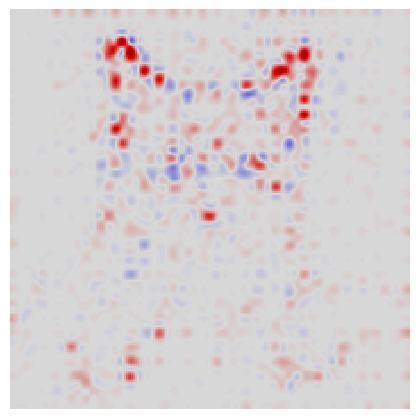

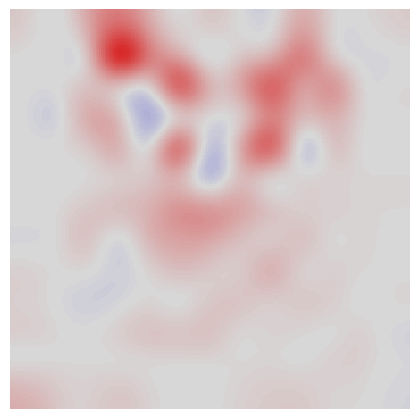

In [9]:
def LRP_process(model, img, layer = 1):
  layerwise_relevance = LRP(model)
  im, pred_cls = process_img(img, model)
  LRP_per_layer = layerwise_relevance.generate(im, pred_cls)
  lrp_to_vis = np.array(LRP_per_layer[layer][0]).sum(axis=0)
  lrp_to_vis = np.array(Image.fromarray(lrp_to_vis).resize((im.shape[2],
                          im.shape[3]), Image.ANTIALIAS))
  heatmap = apply_heatmap(lrp_to_vis, 4, 4)
  return heatmap

def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()

heatmap_1 =LRP_process(pret_mod, img,  layer = 1)
heatmap_7 =LRP_process(pret_mod, img,  layer = 7)

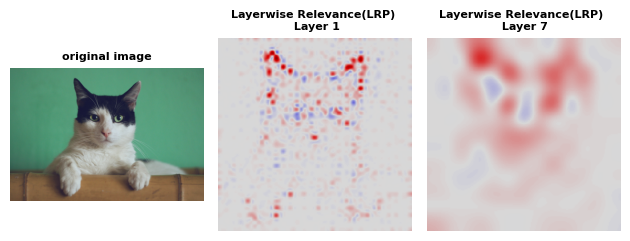

In [10]:
images = [img, heatmap_1, heatmap_7]
captions = ['original image', 'Layerwise Relevance(LRP) \n Layer 1',
            'Layerwise Relevance(LRP) \n Layer 7']
fig = download_images(images, captions, cols = 3, rows = 1, size = 8)

<ipython-input-20-1d99c49f2c51>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.shape[3]), Image.ANTIALIAS))


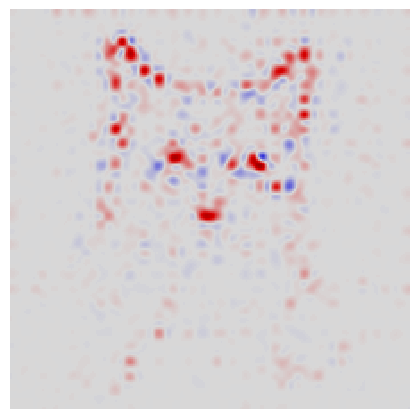

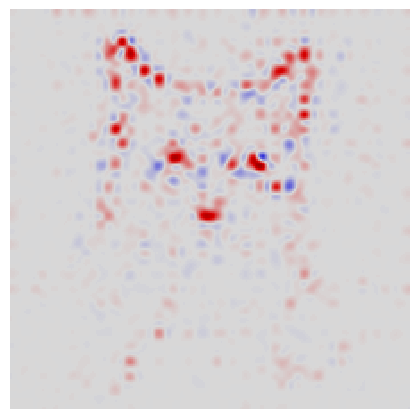

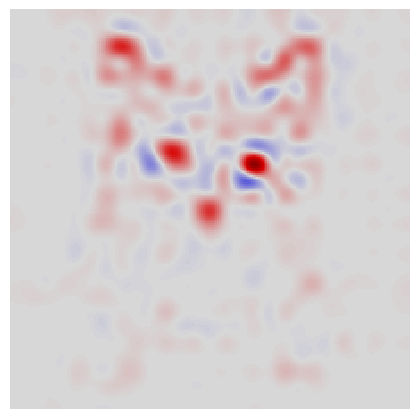

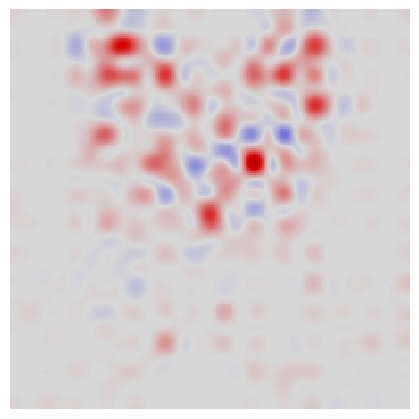

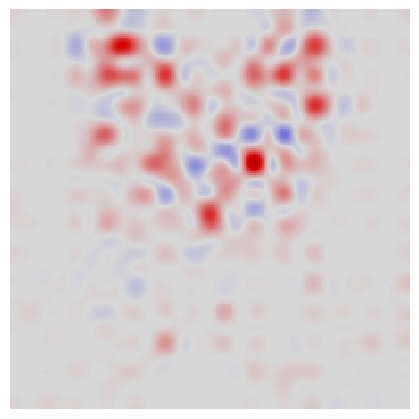

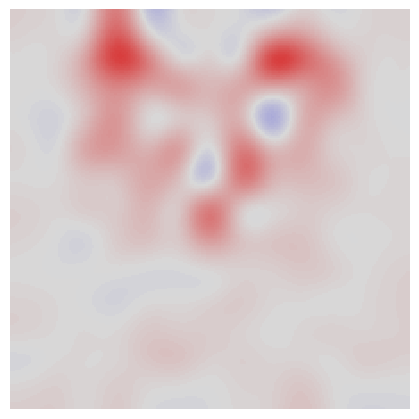

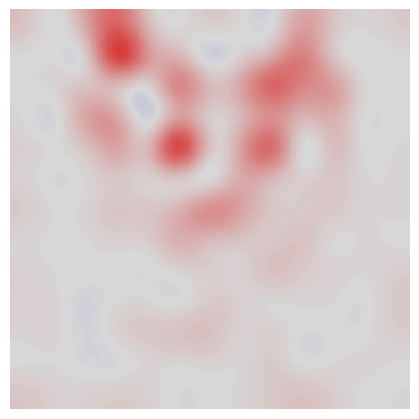

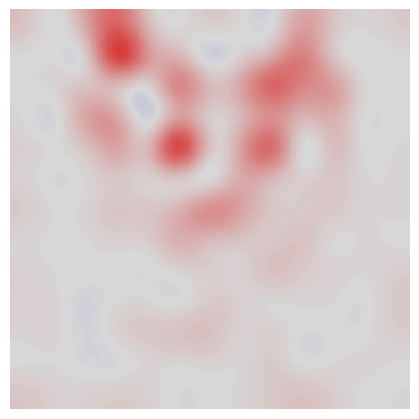

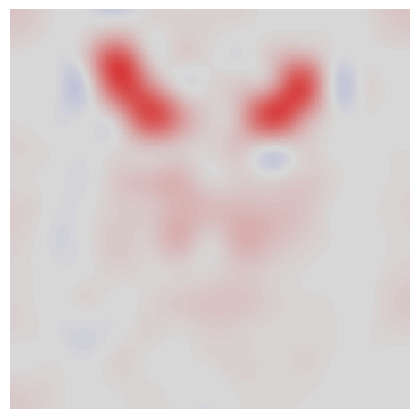

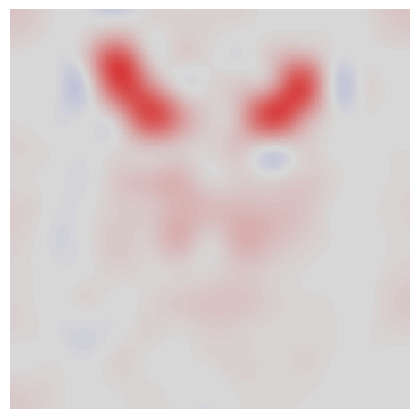

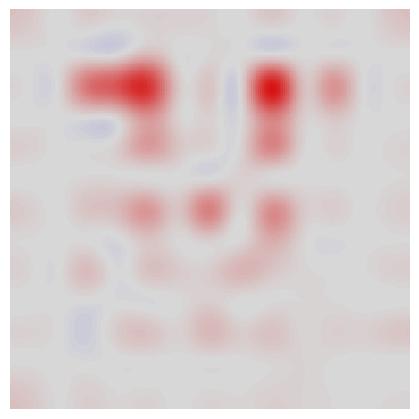

In [20]:
def LRP_process_all_layers(model, img, n_layers=12):
  layerwise_relevance = LRP(model)
  im, pred_cls = process_img(img, model)
  LRP_per_layer = layerwise_relevance.generate(im, pred_cls)
  heat_list = list()
  for layer in range(1,n_layers):
      lrp_to_vis = np.array(LRP_per_layer[layer][0]).sum(axis=0)
      lrp_to_vis = np.array(Image.fromarray(lrp_to_vis).resize((im.shape[2],
                              im.shape[3]), Image.ANTIALIAS))
      heatmap = apply_heatmap(lrp_to_vis, 4, 4)
      heat_list.append(heatmap)
  return heat_list
heat_list =LRP_process_all_layers(pret_mod, img, n_layers=12)

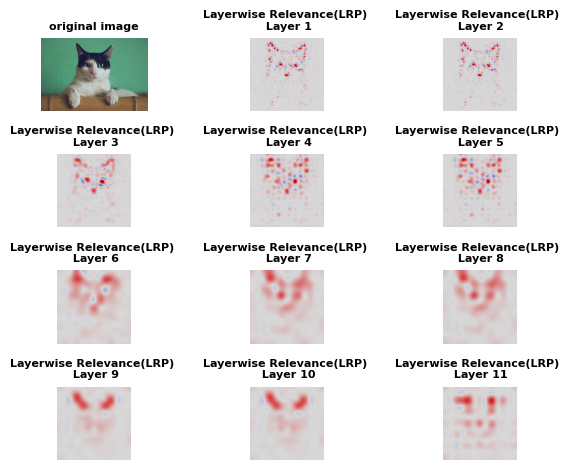

In [25]:
caps = ['Layerwise Relevance(LRP) \n Layer ' +str(i) for i in range(1,12)]
captions =['original image']
captions = captions + caps
images = [img]
images = images + heat_list
fig = download_images(images, captions, cols = 3, rows = 4, size = 8)

In [22]:
len(heat_list)

11